Shapes de los datos cargados:
X_train: (52028, 168) y_train: (52028,)
X_test: (13049, 168) y_test: (13049,)
dates: (65245,)


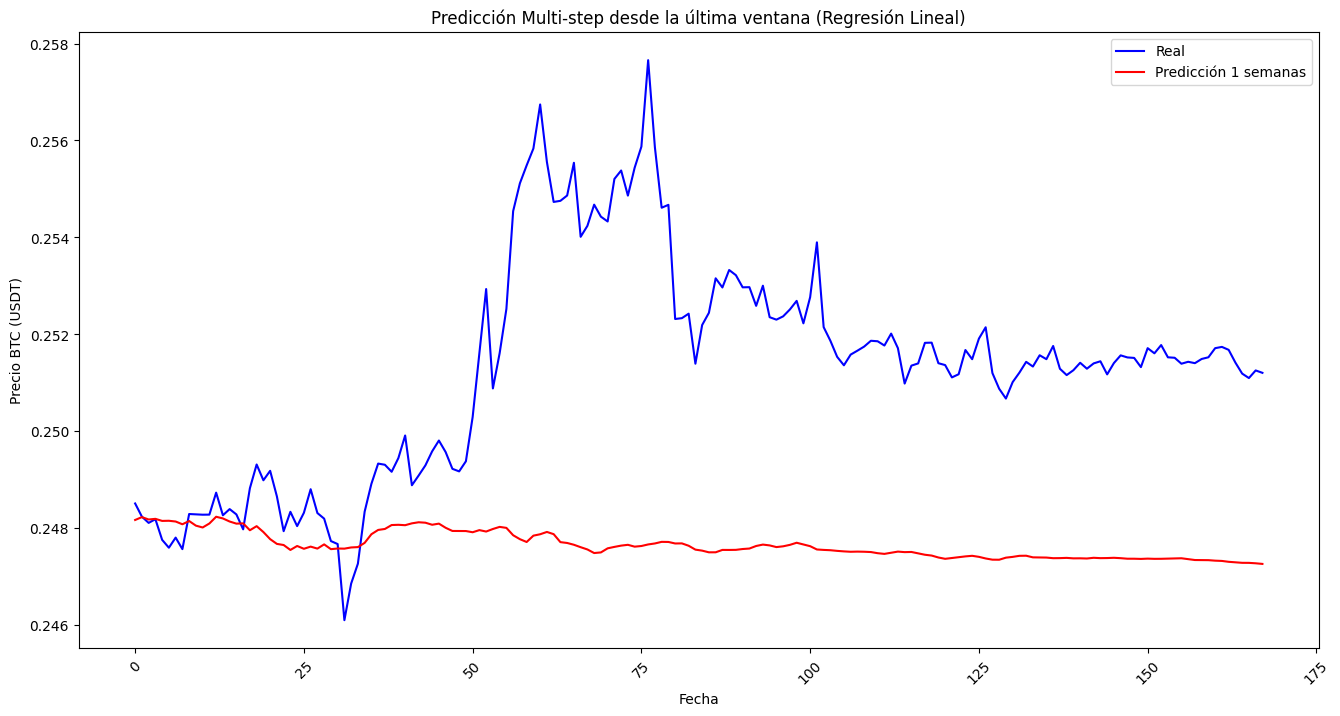

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
from datetime import timedelta
from sklearn.linear_model import LinearRegression

# ===============================
# 1. Cargar datos preprocesados
# ===============================
X_train = np.load("data/X_train.npy")
y_train = np.load("data/y_train.npy")
X_test  = np.load("data/X_test.npy")
y_test  = np.load("data/y_test.npy")
scaler  = joblib.load("data/scaler.pkl")
dates   = np.load("data/dates.npy")  # array de strings o timestamps
train_close_len = np.load("data/train_close_len.npy")

# Convertir 'dates' a datetime (si no lo está)
dates = pd.to_datetime(dates)
print("Shapes de los datos cargados:")
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_test:", X_test.shape, "y_test:", y_test.shape)
print("dates:", dates.shape)

# ===============================
# 2. Entrenar (o cargar) un modelo de Regresión Lineal
# ===============================
linreg_model = LinearRegression()
linreg_model.fit(X_train, y_train)

# ===============================
# 3. Función multi-step iterativo (Regresión Lineal)
# ===============================
def multi_step_forecast_iterative_linreg(model, last_window, steps, scaler=None):
    """
    Predice 'steps' pasos al futuro de forma iterativa usando Regresión Lineal ya entrenada.
    - model: modelo entrenado (linreg_model).
    - last_window: np.array con la última ventana (ej: shape (60,)) en datos normalizados.
    - steps: número de pasos (horas, días, etc.) a predecir.
    - scaler: si se proporciona, desescalamos la predicción a la escala original.
    Retorna: np.array con las predicciones (shape (steps,)).
    """
    window = last_window.copy()
    predictions = []
    for _ in range(steps):
        x_input = window.reshape(1, -1)
        y_pred = model.predict(x_input)[0]
        predictions.append(y_pred)
        window = np.append(window[1:], y_pred)

    predictions = np.array(predictions).reshape(-1, 1)
    return predictions.flatten()

# ===============================
# 4. Mostrar la parte real desde una fecha y la predicción a 15 semanas
# ===============================
start_date_str = "2024-10-01"  # Ejemplo: ver datos reales desde 1 Oct 2024
start_date = pd.to_datetime(start_date_str)

dates_test = dates[train_close_len:]  # Fechas del test
y_test_descaled = scaler.inverse_transform(y_test.reshape(-1,1)).flatten()

# Hallar índice donde arranca 'start_date' en el test
idx_start = np.searchsorted(dates_test, start_date)
idx_start = min(idx_start, len(dates_test)-1)

# ===============================
# 5. Predicción multi-step (15 semanas) desde la última ventana
# ===============================
k_weeks = 1
steps = k_weeks * 7 * 24  # si tus datos son horarios, 15 sem = 15*7*24 = 2520
last_window = X_train[-1]  # la última ventana de X_test

future_preds = multi_step_forecast_iterative_linreg(linreg_model, last_window, steps, scaler=scaler)

# Generar las fechas futuras
last_real_date = dates_test[-1]  # última fecha real
future_dates = [last_real_date + pd.Timedelta(hours=i) for i in range(1, steps+1)]

# Graficar la predicción en otro color, mostrando cada paso con un punto
# Graficar la parte real (en azul) desde start_date
plt.figure(figsize=(16,8))
plt.plot(y_test[:24*7], label="Real", color="blue")
plt.plot(future_preds,  # para que se vean los puntos de cada paso
         label=f"Predicción {k_weeks} semanas", 
         color="red")
plt.title("Predicción Multi-step desde la última ventana (Regresión Lineal)")
plt.xlabel("Fecha")
plt.ylabel("Precio BTC (USDT)")
plt.legend(loc="best")
plt.xticks(rotation=45)
plt.show()